## 4. Walidacja krzyżowa i bootstrap


In [35]:
library(yaml)
library(ggplot2)
library(boot)
library(dplyr)
library(tidyr)

# Global options
options(repr.plot.width = 10, repr.plot.height = 10)

### 4.1 Wczytywanie konfiguracji (*config.yaml*):

In [20]:
config <- yaml.load_file("../config.yaml")

train_filepath <- file.path("..", config$paths$data_train)
test_filepath <- file.path("..", config$paths$data_test)

### 4.2 Przygotowanie danych

Analogicznie jak poprzednio, wczytujemy zbiory treningowy oraz testowy usuwając z nich nieistotne cechy. Tym razem jednak zachowujemy oryginalną zmienną docelową ```elo``` dla zadania regresji.

In [21]:
data_train <- read.csv(train_filepath)
data_test <- read.csv(test_filepath)

data_train$name <- NULL
data_train$games <- NULL

data_test$name <- NULL
data_test$games <- NULL

### 4.3 Walidacja krzyżowa

Dzielimy zbiór treningowy na dwie równe części:
- Faktyczny zbiór treningowy: ```train_set```
- Zbiór walidacyjny: ```validation_set```

In [22]:
set.seed(410375)    # My student index

n_samples <- nrow(data_train)
train_idx <- sample(n_samples, n_samples / 2)

train_set <- data_train[train_idx,]
validation_set <- data_train[-train_idx,]

Analogicznie jak w części poświęconej regresji liniowej, dopasowujemy prosty model liniowy dla jednej zmiennej niezależnej: ```avg_cp_loss```. Tym razem jednak ewaluacji (obliczenie *MSE*) dokonujemy na wydzielonym zbiorze walidacyjnym.

In [23]:
fit_simple <- lm(elo ~ avg_cp_loss, data = train_set)

# Evaluate (validation set)
# - MSE metric
cat("Training set MSE:\n")
mse <- mean((train_set$elo - predict(fit_simple, train_set))^2)
cat(mse, "\n\n")

cat("Validation set MSE:\n")
mse <- mean((validation_set$elo - predict(fit_simple, validation_set))^2)
cat(mse, "\n")

Training set MSE:
63218.58 

Validation set MSE:
62456.77 


Zauważmy, iż błędy na zbiorze treningowym oraz walidacyjnym są podobne, nawet nieco niższy uzyskujemy na zbiorze walidacyjnym. Świadczy to o dobrej generalizacji uzyskanego modelu regresji liniowej.

Zgodnie ze wzorem: $$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}\bigl(y_i - \hat{y}_i\bigr)^2$$ błąd rzędu $\text{MSE} \approx 62500$ uzyskiwany jest przy średniej pomyłce rzędu $250$ punktów rankingowych na gracza.

Teraz testujemy analogiczne podejście, ale dla regresji wielomianowej - dla wielomianów różnych stopni:

In [24]:
for (i in 2:5) {
    fit_poly <- lm(elo ~ poly(avg_cp_loss, degree = i), data = train_set)
    
    train_mse <- mean((train_set$elo       - predict(fit_poly, train_set))      ^ 2)
    val_mse   <- mean((validation_set$elo  - predict(fit_poly, validation_set)) ^ 2)
    
    cat(
        sprintf(
            "Polynomial degree: %d\n------------------------------\nTraining MSE   : %.4f\nValidation MSE : %.4f\n\n",
            i, train_mse, val_mse
        )
    )
}

Polynomial degree: 2
------------------------------
Training MSE   : 61678.7694
Validation MSE : 61280.6854

Polynomial degree: 3
------------------------------
Training MSE   : 61463.2613
Validation MSE : 61094.7370

Polynomial degree: 4
------------------------------
Training MSE   : 61217.9011
Validation MSE : 61024.0028

Polynomial degree: 5
------------------------------
Training MSE   : 61136.2248
Validation MSE : 61079.2057



Jak widać wartości błędu MSE dla zbioru treningowego nieustannie (choć nieznacznie) maleją wraz ze wzrostem stopnia wielomianu. Dla zbioru walidacyjnego widzimy wzrost poziomu błędu przy wielomianie stopnia 5. Może to sugerować drobne przeuczenie, choć różnice są na tyle małe że ciężko wyciągnąć z nich poważniejsze wnioski.

Teraz powtarzamy poprzednie obliczenia, ale dla innego zbioru walidacyjnego (wyznaczonego przez inny seed).

In [25]:
set.seed(410376)    # (Not) My student index

train_idx <- sample(n_samples, n_samples / 2)

train_set <- data_train[train_idx,]
validation_set <- data_train[-train_idx,]

In [26]:
degree_max <- 5
train_mse <- rep(0, times = degree_max)
validation_mse <- rep(0, times = degree_max)

for (i in 1:degree_max) {
  fit_poly <- lm(elo ~ poly(avg_cp_loss, degree = i), data = train_set)
    
  train_mse[i] <- mean((train_set$elo       - predict(fit_poly, train_set))      ^ 2)
  validation_mse[i]   <- mean((validation_set$elo  - predict(fit_poly, validation_set)) ^ 2)
}

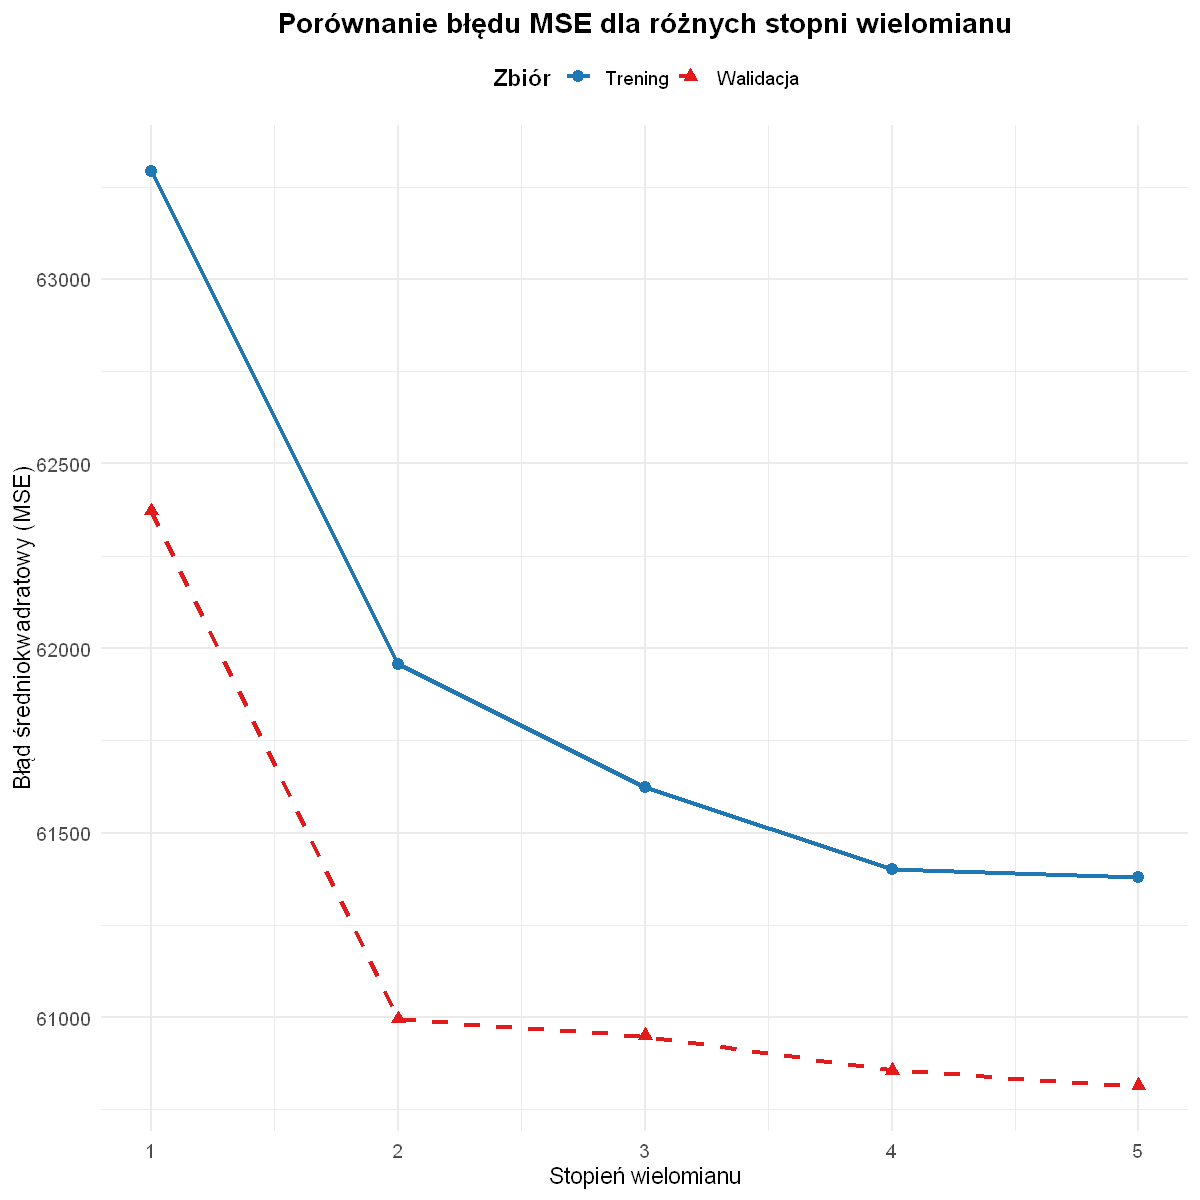

In [27]:
df <- data.frame(
  degree         = 1:degree_max,
  train_mse      = train_mse,
  validation_mse = validation_mse
)

ggplot(df, aes(x = degree)) +
  geom_line(aes(y = train_mse, color = "Trening"), size = 1.2) +
  geom_point(aes(y = train_mse, color = "Trening"), size = 3) +
  geom_line(aes(y = validation_mse, color = "Walidacja"), size = 1.2, linetype = "dashed") +
  geom_point(aes(y = validation_mse, color = "Walidacja"), size = 3, shape = 17) +
  scale_color_manual(values = c("Trening" = "#1f77b4", "Walidacja" = "#e31a1c")) +
  labs(
    x = "Stopień wielomianu",
    y = "Błąd średniokwadratowy (MSE)",
    color = "Zbiór",
    title = "Porównanie błędu MSE dla różnych stopni wielomianu"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    legend.position = "top",
    legend.title = element_text(face = "bold")
  )

Możemy zaobserwować to samo co w poprzednim przypadku - nieznaczny spadek wartości błędu wraz ze wzrostem stopnia wielomianu, zarówno na zbiorze treningowym jak i walidacyjnym.

### 4.4 Walidacja krzyżowa bez jednego (leave-one-out)

Ponieważ *Leave-One-Out Cross-Validation (LOOCV)* jest metodą obciążającą wydajnościowo (dla każdego z $n$ przykładów w zbiorze data_train, trenuje nowy model na $n - 1$ przykładach), zaczynamy od zredukowania rozmiaru zbioru treningowego:

In [28]:
reduced_size <- 1000

train_idx <- sample(n_samples, reduced_size)
data_train_reduced <- data_train[train_idx,]

In [29]:
compute_loocv_mse <- function(degree) {
  elo_glm <- glm(elo ~ poly(avg_cp_loss, degree), data = data_train_reduced)
  cv.glm(data_train_reduced, elo_glm)$delta[1]
}

mse <- sapply(1:degree_max, compute_loocv_mse)
mse

[1] 59529.71 58473.95 58485.91 58452.99 58900.75

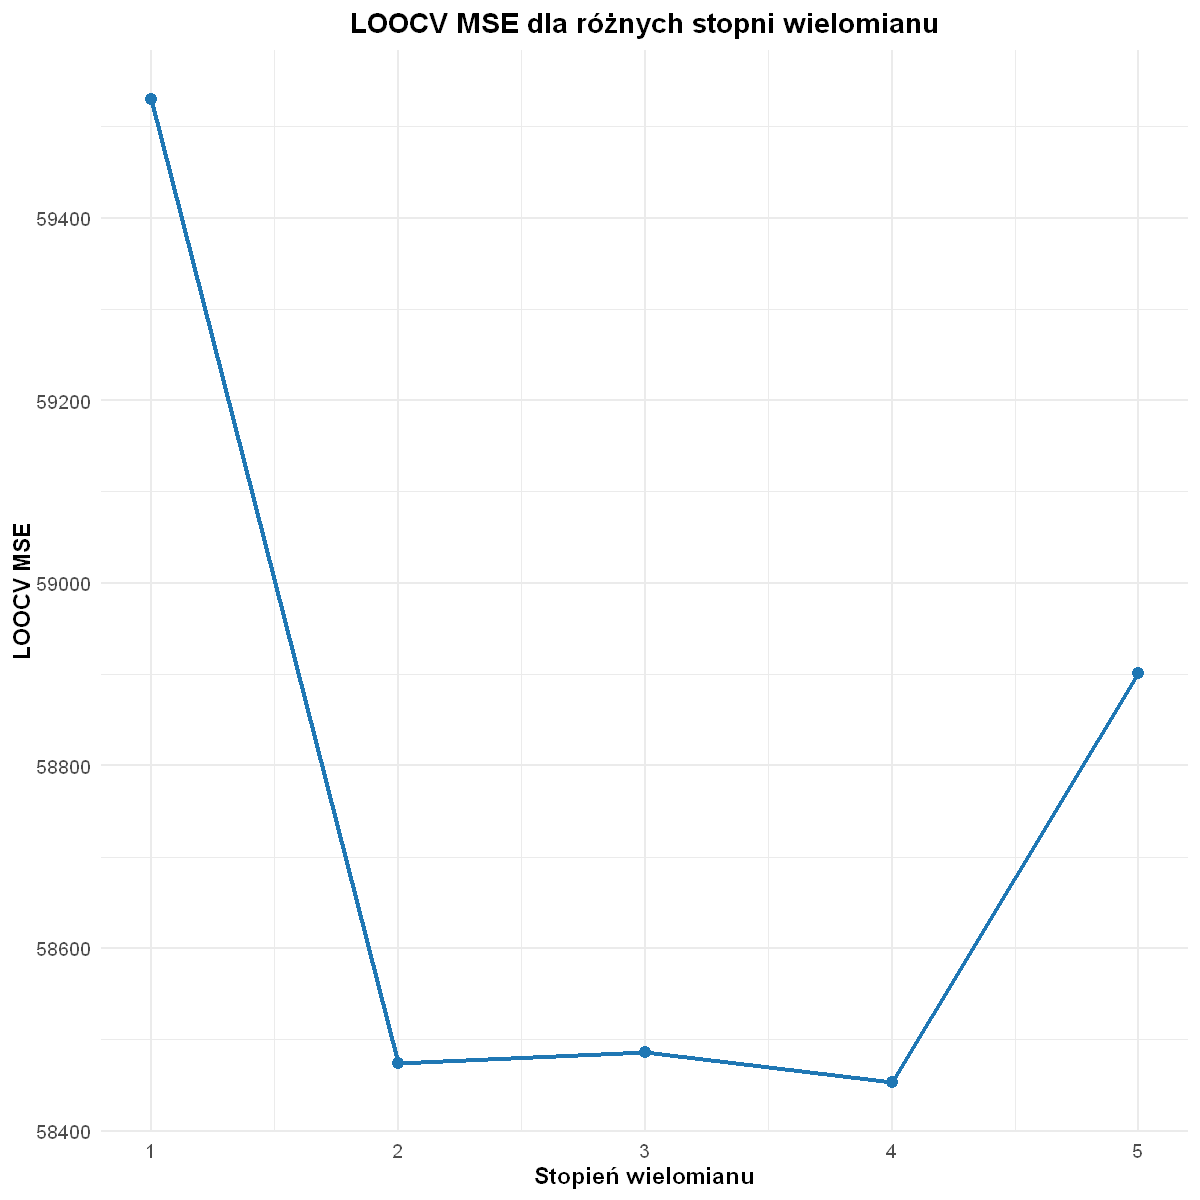

In [30]:
df <- data.frame(
  degree = 1:degree_max,
  mse    = mse
)

ggplot(df, aes(x = degree, y = mse)) +
  geom_line(color = "#1f77b4", size = 1.2) +
  geom_point(color = "#1f77b4", size = 3) +
  labs(
    title = "LOOCV MSE dla różnych stopni wielomianu",
    x = "Stopień wielomianu",
    y = "LOOCV MSE"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    axis.title = element_text(face = "bold")
  )

Widzimy, iż w tym przypadku najmniejszy błąd uzyskujemy dla wielomianu stopnia $p = 3$, choć trzeba zaznaczyć, że różnice są jeszcze mniejsze niż w przypadku standardowej walidacji krzyżowej.

### 4.5 $k$-krotna walidacja krzyżowa

Podobnie jak poprzednio, wykorzystujemy zredukowany zbiór treningowy.

In [31]:
compute_kcv_mse <- function(degree, k) {
  elo_glm <- glm(elo ~ poly(avg_cp_loss, degree), data = data_train_reduced)
  cv.glm(data_train_reduced, elo_glm, K = k)$delta[1]
}

mse <- sapply(1:degree_max, compute_kcv_mse, k = 10)
mse

[1] 59442.77 58415.27 58604.98 58352.95 58579.14

In [32]:
mse10 <- replicate(10, sapply(1:degree_max, compute_kcv_mse, k = 10))
mse10

59434.32,59523.17,59596.38,59482.07,59656.79,59679.71,59562.51,59487.35,59489.00,59630.82
58341.73,58444.22,58357.72,58553.17,58540.16,58407.51,58405.18,58550.97,58473.10,58496.45
58488.44,58487.48,58551.82,58509.92,58491.34,58541.86,58813.16,58754.82,58288.85,58417.57
58576.77,58438.69,58516.82,58665.07,58348.97,58372.54,58520.42,58576.82,58399.27,58345.46
59291.18,58822.30,59011.86,58984.83,58968.77,58756.52,59376.73,59173.80,59748.16,59363.47


Na podstawie 10-krotnej walidacji krzyżowej, powtórzonej dziesięć razy dla każdego stopnia wielomianu, można stwierdzić, że wartości błędu średniokwadratowego (MSE) są stabilne — odchylenia pomiędzy powtórzeniami są niewielkie, co świadczy o wiarygodności wyników. Średni MSE osiąga minimum dla stopni w okolicach 3–4, co sugeruje, że modele o tych stopniach najlepiej dopasowują się do danych bez nadmiernego przeuczenia. Dla wyższych stopni (powyżej 5) nie obserwuje się dalszej poprawy błędu, a nawet widoczny jest lekki wzrost MSE, co wskazuje na ryzyko przeuczenia modelu.

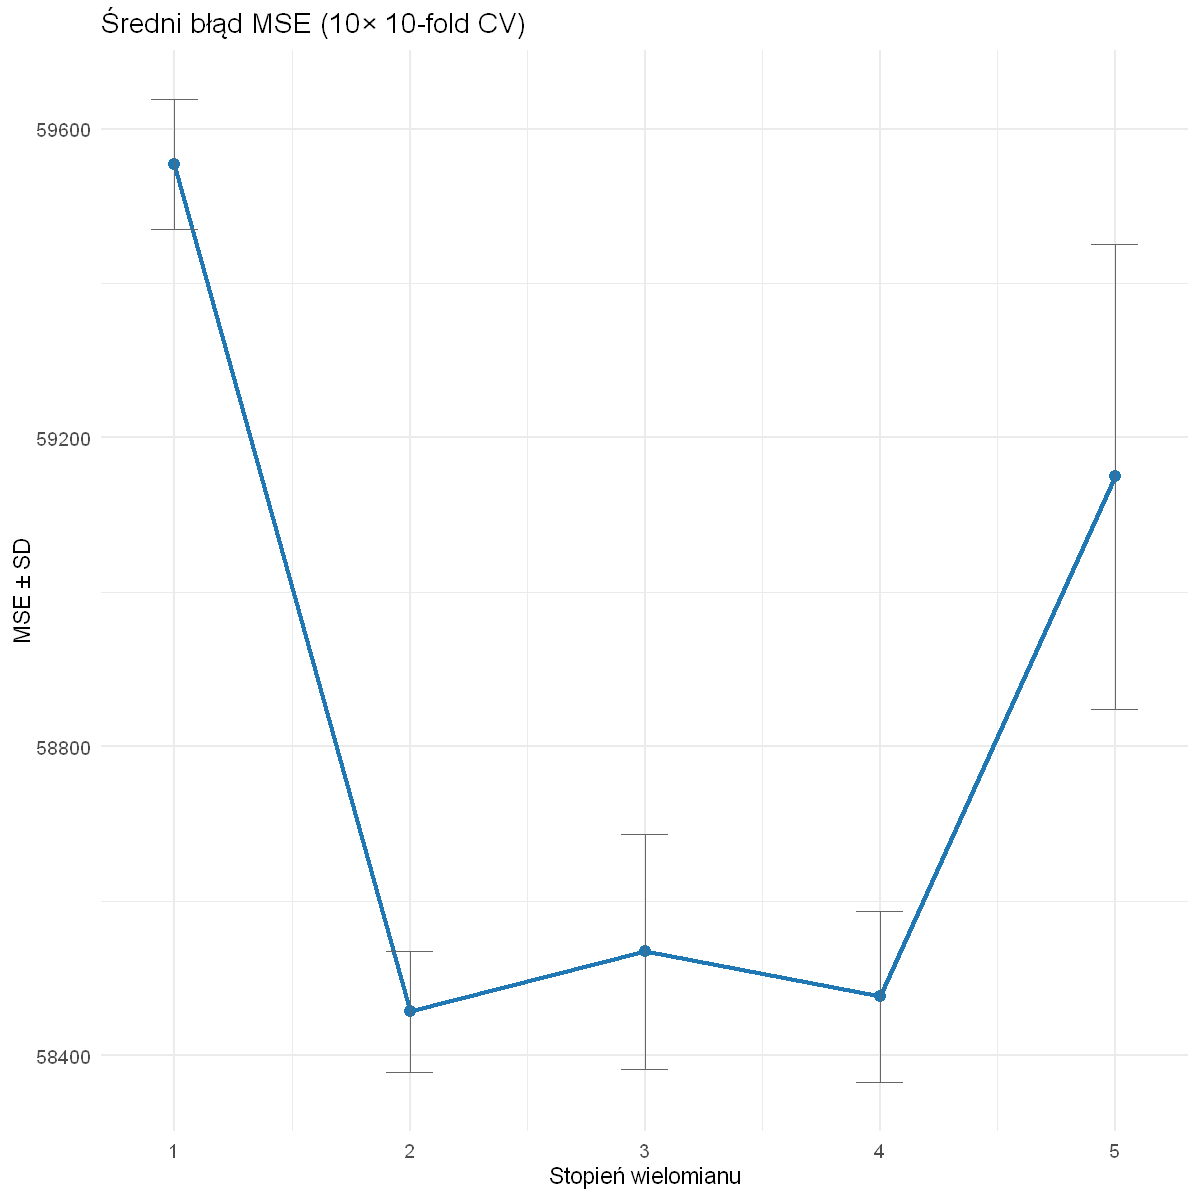

In [38]:
degree_max <- nrow(mse10)
rep_count <- ncol(mse10)

df <- as.data.frame(mse10)
df$degree <- 1:degree_max

df_long <- pivot_longer(df, cols = -degree,
                        names_to = "rep", values_to = "mse")

summary_df <- df_long %>%
  group_by(degree) %>%
  summarise(
    mean_mse = mean(mse),
    sd_mse = sd(mse),
    .groups = "drop"
  )

ggplot(summary_df, aes(x = degree, y = mean_mse)) +
  geom_line(color = "#1f77b4", size = 1.2) +
  geom_point(size = 3, color = "#1f77b4") +
  geom_errorbar(aes(ymin = mean_mse - sd_mse, ymax = mean_mse + sd_mse),
                width = 0.2, color = "gray40") +
  labs(
    title = "Średni błąd MSE (10× 10-fold CV)",
    x = "Stopień wielomianu",
    y = "MSE ± SD"
  ) +
  theme_minimal(base_size = 14)

Podobnie jak w przypadku LOOCV, najlepiej sprawdzają się wielomiany o umiarkowanym stopniu. Warto również zauważyć, iż zwiększanie stopnia wielomianu prowadzi do zwiększania wariancji (żeby być precyzyjnym - właściwie odchylenia standardowego) błędów MSE uzyskiwanych dla poszczególnych foldów walidacji krzyżowej. Świadczy to o rosnącej niestabilności modelu, który staje się coraz bardziej wrażliwy na konkretne podziały danych treningowych. Może to wskazywać na przeuczenie, gdzie model dopasowuje się do szumu w danych zamiast do rzeczywistego trendu.

### 4.6 Bootstrap

In [39]:
lm_coefs <- function(data, index = 1:nrow(data)) {
  coef(lm(elo ~ avg_cp_loss, data = data, subset = index))
}

In [43]:
cat("Original dataset results:\n")
lm_coefs(data_train)

cat("\nBootstraped dataset results:\n")
lm_coefs(data_train, sample(n_samples, n_samples, replace = TRUE))

Original dataset results:


(Intercept) avg_cp_loss 
 2493.99740   -11.74407


Bootstraped dataset results:


(Intercept) avg_cp_loss 
 2487.47538   -11.68287

In [44]:
boot(data_train, lm_coefs, R = 1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data_train, statistic = lm_coefs, R = 1000)


Bootstrap Statistics :
      original       bias    std. error
t1* 2493.99740 -0.292718702    8.391157
t2*  -11.74407  0.001767963    0.100575

Z powyższych wyników możemy wysnuć następujące wnioski:
- **Mały bias**: wartości współczynników w próbkach bootstrapowych są bardzo bliskie wartościom z pełnego zbioru — oznacza to, że model jest stabilny względem losowych fluktuacji danych.
- **Błąd standardowy** pokazuje, jak bardzo mogłyby się zmieniać oszacowania współczynników przy zmianie danych — jest umiarkowany (szczególnie mały dla nachylenia).

Wynika stąd, iż model regresji liniowej jest stabilny i wiarygodny, a oszacowany wpływ avg_cp_loss na elo jest negatywny, istotny i dobrze oszacowany. Niewielka wariancja i bias współczynników oznacza, że model nie jest nadmiernie wrażliwy na konkretne obserwacje treningowe.